# Анализ данных для интернет-магазина продуктов питания

Заказчик исследования - стартап, который продает продукты питания онлайн. Цель анализа - разобраться в поведении пользователей мобильного приложения, построить воронку продаж и исследовать результаты A/A/B-эксперимента,  где тестировались разные шрифты.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#План-работ:" data-toc-modified-id="План-работ:-1">План работ:</a></span></li><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-2">Описание данных</a></span></li><li><span><a href="#Общая-информация" data-toc-modified-id="Общая-информация-3">Общая информация</a></span></li><li><span><a href="#Изучение-и-проверка-данных" data-toc-modified-id="Изучение-и-проверка-данных-4">Изучение и проверка данных</a></span></li><li><span><a href="#Воронка-продаж" data-toc-modified-id="Воронка-продаж-5">Воронка продаж</a></span><ul class="toc-item"><li><span><a href="#Уникальные-пользователи-и-пересечения-id" data-toc-modified-id="Уникальные-пользователи-и-пересечения-id-5.1">Уникальные пользователи и пересечения id</a></span></li><li><span><a href="#Воронка-продаж" data-toc-modified-id="Воронка-продаж-5.2">Воронка продаж</a></span></li></ul></li><li><span><a href="#Результаты-эксперимента" data-toc-modified-id="Результаты-эксперимента-6">Результаты эксперимента</a></span><ul class="toc-item"><li><span><a href="#Проверка-групп-246-и-247-по-всем-событиям" data-toc-modified-id="Проверка-групп-246-и-247-по-всем-событиям-6.1">Проверка групп 246 и 247 по всем событиям</a></span></li><li><span><a href="#Проверка-групп-246-и-248-по-всем-событиям" data-toc-modified-id="Проверка-групп-246-и-248-по-всем-событиям-6.2">Проверка групп 246 и 248 по всем событиям</a></span></li><li><span><a href="#Проверка-групп-247-и-248-по-всем-событиям" data-toc-modified-id="Проверка-групп-247-и-248-по-всем-событиям-6.3">Проверка групп 247 и 248 по всем событиям</a></span></li><li><span><a href="#Проверка-групп-246+247-и-248-по-всем-событиям" data-toc-modified-id="Проверка-групп-246+247-и-248-по-всем-событиям-6.4">Проверка групп 246+247 и 248 по всем событиям</a></span></li></ul></li><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-7">Вывод:</a></span><ul class="toc-item"><li><span><a href="#Проделанные-работы:" data-toc-modified-id="Проделанные-работы:-7.1">Проделанные работы:</a></span></li><li><span><a href="#Заключение:" data-toc-modified-id="Заключение:-7.2">Заключение:</a></span></li></ul></li></ul></div>

## План работ:


- изучение общей информации
- подготовка данных (проверка пропусков, типов данных, добавление столбца с датами)
- изучение данных: количество событий и пользователей, среднее количество событий на пользователей, построение гистрограммы по дате и времени, фильтрация датасета по временному срезу
- воронка событий: сортировка событий по частоте и по числу пользователей, расчет доли пользователей, которые хоть раз совершали событие, анализ количества пользователей на каждом шаге воронке и количества пользователей, которые доходят до оплаты
- результаты A/A/B эксперимента: сравнения групп A/A, A/B и A/A/B
- выводы


## Описание данных
Каждая запись в логе — это действие пользователя, или событие:

EventName — название события;  
DeviceIDHash — уникальный идентификатор пользователя;  
EventTimestamp — время события;  
ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.  

## Общая информация


Импортируем нужные библиотеки и загрузим файл с данными:

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
from plotly import graph_objects as go

import warnings
warnings.filterwarnings("ignore")

import scipy.stats as stats
import math as mth
!pip install -U kaleido

In [2]:
data = pd.read_csv(R'C:\Users\balue\Downloads\logs_exp.csv', sep='\t')

Датасет состоит из 4 столбцов с названием и временем события, id пользователя и номером эксперимента:

In [3]:
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Всего в датасете 244126 строк:

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Убедимся, что пропусков нет:

In [5]:
data.isna().sum()

EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

В датасете обнаружено 413 дубликатов, которые лучше удалить:

In [6]:
data.duplicated().sum()

413

In [7]:
data = data.drop_duplicates()
data.duplicated().sum()

0

Для удобства переименуем столбцы:

In [8]:
data.rename(
    columns={'EventName' : 'event_name', 'DeviceIDHash' : 'user_id', 
             'EventTimestamp' : 'event_timestamp', 'ExpId' : 'exp_id'}, inplace=True)


In [9]:
data.head()

,event_name,user_id,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Создадим столбец даты и времени, а также отдельный столбец дат:

In [10]:
data['event_timestamp'] = pd.to_datetime(data['event_timestamp'],  unit='s')
data['date'] = data['event_timestamp'].dt.floor('D')


In [11]:
data.head()

,event_name,user_id,event_timestamp,exp_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


Проверим уникальные значения категориальных данных:

In [12]:
data['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

## Изучение и проверка данных



Изучим данные:

Всего событий в логе 243713:

In [13]:
data['event_name'].count()

243713

События распределены по типам следующим образом:

In [14]:
data['event_name'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

Уникальных пользователей в логе 7551 человек:

In [15]:
data['user_id'].nunique()

7551

В среднем на пользователя приходится 32 события:

In [16]:
avg_events = data['event_name'].count() / data['user_id'].nunique()
round(avg_events)

32

Мы располагаем данными с 25 июля 2019 по 7 августа 2019:

In [17]:
# найдем минимальную и максимальную дату в логе
print (data['date'].min())
print (data['date'].max())

2019-07-25 00:00:00
2019-08-07 00:00:00


Построим гистограмму распределения событий по времени:

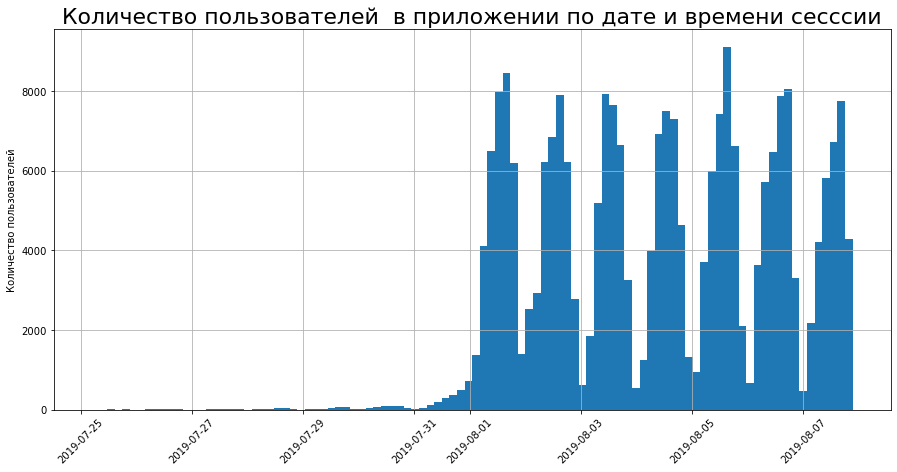

In [18]:
data['event_timestamp'].hist(figsize=(15, 7), bins=100)
plt.title('Количество пользователей  в приложении по дате и времени сесссии', fontsize=22)
plt.xticks(rotation=45)
plt.ylabel('Количество пользователей');

Видно, что большая часть событий приходится на период с 01 по 07 августа 2019. Пики использования приложения относятся к дневному времени. Видимо, переданный лог содержит неполные данные, так как в нем содержится очень мало событий, произошедших до 01 августа 2019.

Построим таблицу с количеством  пользователей по дням:

In [19]:
data_by_dates = data.pivot_table(index='date', values='user_id', aggfunc='count').reset_index()
data_by_dates

,date,user_id
0,2019-07-25,9
1,2019-07-26,31
2,2019-07-27,55
3,2019-07-28,105
4,2019-07-29,184
5,2019-07-30,412
6,2019-07-31,2030
7,2019-08-01,36141
8,2019-08-02,35554
9,2019-08-03,33282


Видно, что полные данные собраны в период с 01 по 07 августа. Поэтому отфильтруем датасет и  продолжим работу только с этим временным отрезком.

После фильтрации осталось 240887 событий:

In [20]:
data_filtered = data.query('date > "2019-07-31"')

data_filtered['event_name'].count() 

240887

После фильтрации осталось 7534 уникальных пользователя:

In [21]:
data_filtered['user_id'].nunique()

7534

После фильтрации по датам, большая часть данных осталась в датасете (98.8% событий и 99.8% пользователей):

In [22]:
print (round(data_filtered['event_name'].count() / data['event_name'].count() * 100, 1))
print (round(data_filtered['user_id'].nunique() / data['user_id'].nunique() * 100, 1))

98.8
99.8


Проверим, что у нас есть пользователи из всех трёх экспериментальных групп и группы схожи по размеру:

In [23]:
# создадим сводную таблицу, где количество уникальных пользователей рассчитано по группам
data_groups = data_filtered.pivot_table(index='exp_id', values='user_id', aggfunc='nunique').reset_index()
data_groups

,exp_id,user_id
0,246,2484
1,247,2513
2,248,2537


Убедмся, что не существует пользователей, которые вошли одновременно в 2 или в 3 группы:

In [24]:
# создадим отдельные списки id участников каждой из трех групп
group_246 = data_filtered.loc[data_filtered['exp_id'] == 246, 'user_id']
group_247 = data_filtered.loc[data_filtered['exp_id'] == 247, 'user_id']
group_248 = data_filtered.loc[data_filtered['exp_id'] == 248, 'user_id']

# найдем пересечения, то есть id, которые встречаются хотя бы в двух группах их трех
intersection1 = list(set(group_246) & set(group_247))
intersection2 = list(set(group_246) & set(group_248))
intersection3 = list(set(group_247) & set(group_248))

print (intersection1)
print (intersection2)
print (intersection3)

[]
[]
[]


Проверим то же самое другим способом:

In [25]:
len(data_filtered.groupby('user_id').agg({'exp_id':'nunique'}).query('exp_id > 1'))

0

Убедимся, что для всех трех групп данные собирались в один и тот же период:

In [26]:
group_246 = data_filtered.loc[data_filtered['exp_id'] == 246, 'date']
group_247 = data_filtered.loc[data_filtered['exp_id'] == 247, 'date']
group_248 = data_filtered.loc[data_filtered['exp_id'] == 248, 'date']

groups = [group_247, group_247, group_248]

for group in groups:
    print (group.min())
    print (group.max())


2019-08-01 00:00:00
2019-08-07 00:00:00
2019-08-01 00:00:00
2019-08-07 00:00:00
2019-08-01 00:00:00
2019-08-07 00:00:00


##  Воронка продаж


Проверим, какие события есть в логах и как часто они встречаются. 



In [27]:
data_filtered['event_name'].value_counts() 

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

Наиболее частое событие - MainScreenAppear, то есть открытие главной страницы.  
Наименее частое - Tutorial - то есть изучение инструкций на сайте.

События выстраиваются в следующем порядке:   
MainScreenAppear ->   
OffersScreenAppear ->   
CartScreenAppear	->   
PaymentScreenSuccessful,   

или:

Главная страница ->    
Страница с предложениями ->    
Корзина ->    
Страница успешной оплаты   

Tutorial не входит в воронку покупок, поэтому в дальнейшем не будем учитывать этот этап.



### Уникальные пользователи и пересечения id

Проверим число уникальных пользователей, которые совершали то или иное действие и доли пользователей от общего числа:

In [28]:
# исключим Tutorial из списка событий
data_filtered = data_filtered.query('event_name != "Tutorial"')

# отфильтруем события по числу пользователей
data_events = data_filtered.pivot_table(index='event_name', values='user_id', aggfunc='nunique').reset_index()
data_events  = data_events.sort_values(by='user_id', ascending=False)
data_events['percentage'] = round(data_events['user_id'] /  data_filtered['user_id'].nunique()  * 100, 2)

data_events

,event_name,user_id,percentage
1,MainScreenAppear,7419,98.53
2,OffersScreenAppear,4593,61.00
0,CartScreenAppear,3734,49.59
3,PaymentScreenSuccessful,3539,47.00


Проверим число уникальных пользователей в каждой группе, которые совершали то или иное событие.   
Видно, что количество пользователей в разных группах приблизительно одинаково:

In [29]:
data_events = data_filtered.pivot_table(index='event_name', values='user_id', columns='exp_id', aggfunc='nunique').reset_index()

data_events.sort_values(by=246, ascending=False)

exp_id,event_name,246,247,248
1,MainScreenAppear,2450,2476,2493
2,OffersScreenAppear,1542,1520,1531
0,CartScreenAppear,1266,1238,1230
3,PaymentScreenSuccessful,1200,1158,1181


Проверим пересечения id на разных этапах воронки. 

Видно, что в некоторых группах есть пользователи, которые пропускали этапы: совершали действия второго этапа, но не первого, или третьего, но не второго итд.

Такой вывод можно сделать, так как количество пересекающихся id, например, между первым и вторым этапом меньше, чем общее количество id на втором этапе. Возможно, некоторые действия пользователей не вошли в наш временной срез:

In [30]:
# создадим списки уникальных id на каждом этапе воронки
MainScreenAppear_ids = data_filtered.loc[data_filtered['event_name'] == "MainScreenAppear", 'user_id'].unique()
OffersScreenAppear_ids = data_filtered.loc[data_filtered['event_name'] == "OffersScreenAppear", 'user_id'].unique()
CartScreenAppear_ids = data_filtered.loc[data_filtered['event_name'] == "CartScreenAppear", 'user_id'].unique()
PaymentScreenSuccessful_ids = data_filtered.loc[data_filtered['event_name'] == "PaymentScreenSuccessful", 'user_id'].unique()

# проверим пересечения id между этапами и найдем количество id, которые вошли в оба этапа
inter1 = list(set(MainScreenAppear_ids) & set(OffersScreenAppear_ids))
print (len(inter1))
inter2 = list(set(CartScreenAppear_ids) & set(OffersScreenAppear_ids))
print (len(inter2))
inter3 = list(set(CartScreenAppear_ids) & set(PaymentScreenSuccessful_ids))
print (len(inter3))



4482
3679
3534


### Воронка продаж

Построим воронку продаж для всех трех групп:

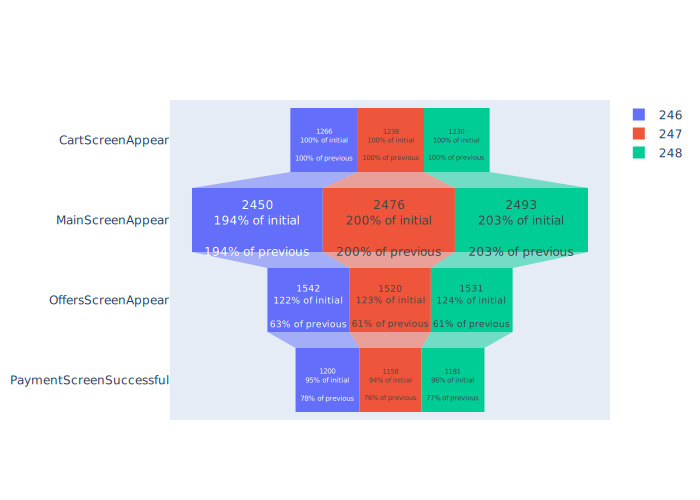

In [31]:
from plotly import graph_objects as go
import plotly.io as pio
pio.renderers.default = "browser"

fig = go.Figure()

fig.add_trace(go.Funnel(
    name = '246',
    orientation = "h",
    y = data_events['event_name'],
    x = data_events[246],
    textinfo = "value+percent initial+percent previous"))

fig.add_trace(go.Funnel(
    name = '247',
    orientation = "h",
    y = data_events['event_name'],
    x = data_events[247],
    textposition = "inside",
    textinfo = "value+percent initial+percent previous"))

fig.add_trace(go.Funnel(
    name = '248',
    orientation = "h",
    y = data_events['event_name'],
    x = data_events[248],
    textposition = "inside",
    textinfo = "value+percent initial+percent previous"))

fig.show(renderer="svg")

Визуально не видно больших различий между группами, и показатели схожи.

Построим аналогичную таблицу, где рассчитаем доли посетителей каждой страницы по отношению к посетителям предыдущей страницы и количеству всех пользователей:

In [32]:
# отсортируем события по порядку

data_events = data_events.sort_values(by=246, ascending=False)

# рассчитаем процент удержания по отношению к начальному и к предыдущему этапу для каждой группы:

data_events['perc_of_prev_246'] = round(data_events[246].div(data_events[246].shift(1))  * 100, 1)
data_events['perc_of_init_246'] = round(data_events[246].div(data_events[246].iloc[0])  * 100,1)

data_events['perc_of_prev_247'] = round(data_events[247].div(data_events[247].shift(1))  * 100, 1)
data_events['perc_of_init_247'] = round(data_events[247].div(data_events[247].iloc[0])  * 100,1)

data_events['perc_of_prev_248'] = round(data_events[248].div(data_events[248].shift(1))  * 100, 1)
data_events['perc_of_init_248'] = round(data_events[248].div(data_events[248].iloc[0])  * 100,1)

data_events.sort_values(by=246, ascending=False)

exp_id,event_name,246,247,248,perc_of_prev_246,perc_of_init_246,perc_of_prev_247,perc_of_init_247,perc_of_prev_248,perc_of_init_248
1,MainScreenAppear,2450,2476,2493,NaN,100.0,NaN,100.0,NaN,100.0
2,OffersScreenAppear,1542,1520,1531,62.9,62.9,61.4,61.4,61.4,61.4
0,CartScreenAppear,1266,1238,1230,82.1,51.7,81.4,50.0,80.3,49.3
3,PaymentScreenSuccessful,1200,1158,1181,94.8,49.0,93.5,46.8,96.0,47.4


По таблице и воронке видно, что наибольший процент пользователей, совершивших покупку - в группе 246 (49%).
Во всех группах пользователи удерживаются примерно одинаково и хорошо, а больше всего пользователей в каждой группе 'теряется' при переходе с первого на второй этап (c главной страницы на страницу предложений переходят 60-62% пользователей).

До оплаты доходит 46-49% пользователей - самые высокие показатели в группе 246 (49%).

## Результаты эксперимента

Проверим результаты эксперимента - подсчитаем количество пользователей в каждой экспериментальной группе. Сравним результаты между группами A1/A2, A1/B, A2/B, A1+A2/B, где:

A1 и A2 - контрольные группы (246 и 247), B - группа с измененным шрифтом (248).  

Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между ними.


Проверим еще раз, сколько всего пользователей в каждой экспериментальной группе:

In [33]:
data_filtered_groups =  data_filtered.pivot_table(columns='exp_id', values='user_id', aggfunc='nunique')
data_filtered_groups

exp_id,246,247,248
user_id,2483,2512,2535


Количество пользователей примерно одинаковое.



Выберем самое популярное событие (MainScreenAppear - 'главная страница') и подсчитаем количество посетителей в группах. Проверим, сколько уникальных пользователей из каждой группы зашли на главную страницу.

Больше всего пользователей на страницу зашли из группы 248 - 2535 человек, а в целом на главную страницу зашли 98% пользователей из каждой группы. Возможно, остальные пользователи тоже заходили на главную страницу, но эти данные не попали во временной фильтр.

In [34]:
# создадим датасет с количеством уникальных пользователей по группам
data_filtered_all = data_filtered.pivot_table(index='exp_id', values='user_id', aggfunc='nunique').reset_index()

# создадим датасет с количеством уникальных пользователей по группам, зашедших на главную страницу
data_filtered_msa = data_filtered.query('event_name == "MainScreenAppear"')
data_filtered_msa = data_filtered_msa.pivot_table(index='exp_id', values='user_id', aggfunc='nunique').reset_index()

# объединим два датасета
merged = data_filtered_all.merge(data_filtered_msa, on='exp_id')                                     

merged['percentage'] = round(merged['user_id_y'] / merged['user_id_x'] * 100, 1)
merged = merged.rename(columns={'user_id_x' : 'all_visitors', 'user_id_y' : 'main_screen_visitors'})
merged


,exp_id,all_visitors,main_screen_visitors,percentage
0,246,2483,2450,98.7
1,247,2512,2476,98.6
2,248,2535,2493,98.3


Проверим, насколько статистически значимы различия между группами. 

Сформулируем нулевую и альтернативную гипотезы:

- Нулевая гипотеза: между группами 246 и 247 нет значимых различий  
- Альтернативная гипотеза:  между группами 246 и 247 есть статистически значимые различия 

Уровень значимости alpha = 0.005



In [35]:

# подсчитаем количество уникальных посетителей главной страницы и количество всех уникальных посетителей в группе 246
visitors_246_msa = data_filtered.query('exp_id == 246 & event_name == "MainScreenAppear"').agg({'user_id' : 'nunique'})
visitors_246_all = data_filtered.query('exp_id == 246').agg({'user_id' : 'nunique'})

# подсчитаем количество уникальных посетителей главной страницы и количество всех уникальных посетителей в группе 247
visitors_247_msa = data_filtered.query('exp_id == 247 & event_name == "MainScreenAppear"').agg({'user_id' : 'nunique'})
visitors_247_all= data_filtered.query('exp_id == 247').agg({'user_id' : 'nunique'})

alpha = .005 # критический уровень статистической значимости

# Пропорция успехов в группах
p246 = visitors_246_msa/visitors_246_all
p247 = visitors_247_msa/visitors_247_all
 
# Пропорция успехов в комбинированном датасете:
p_combined = (visitors_246_msa + visitors_247_msa)/(visitors_246_all + visitors_247_all)
 
# Разница конверсий/# разница пропорций в датасетах
p_diff = p246 - p247
 
# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = p_diff / mth.sqrt(p_combined * (1 - p_combined) * (1/visitors_246_all + 1/visitors_247_all))
 
# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = stats.norm(0, 1)
 
p_value = (1 - distr.cdf(abs(z_value))) * 2
 
print('p-value:',p_value)
 
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между группами есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, между группами нет значимой разницы")

 



p-value: [0.75267034]
Не получилось отвергнуть нулевую гипотезу, между группами нет значимой разницы


### Проверка групп 246 и 247 по всем событиям

Согласно полученным результатам, нет значимой разницы между группами 246 и 247 относительно посещения главной страницы.

Проверим теперь, существует ли разница между группами в отношении остальных событий:

Сформулируем нулевую и альтернативную гипотезы:

- Нулевая гипотеза: между группами 246 и 247 нет значимых различий  
- Альтернативная гипотеза:  между группами 246 и 247 есть статистически значимые различия 

Уровень значимости alpha = 0.004

Применим поправку Бонферрони на множественную проверку гипотез.
Для расчета поправки учитываем 12 тестов (А1/А2, А1/В, А2/В).     
4 теста (А1+А2)/В не учитываем, так как они дублируют тесты А1/В, А2/В.

При alpha = 0.05 вероятность ошибки в 12 тестах составляет (1-0.05)^12= 46%.

Поэтому будем проводить тест при alpha=0.004. C учетом поправки, вероятность ошибиться будет составлять 5%: 1-(1-0.004)^12= 5%

Выведем на экран p-value, рассчитанный по z-value:



In [36]:
# рассчитаем количество уникальных пользователей обеих групп
visitors_246_all = data_filtered.query('exp_id == 246').agg({'user_id' : 'nunique'})
visitors_247_all = data_filtered.query('exp_id == 247').agg({'user_id' : 'nunique'})


for name, group in data_filtered.groupby('event_name'):
     
    # подсчитаем количество уникальных посетителей экрана 1 и всех посетителей в группе 246
    visitors_246_event = group.query('exp_id == 246').agg({'user_id' : 'nunique'})


# подсчитаем количество уникальных посетителей экрана 1 и всех посетителей в группе 247
    visitors_247_event = group.query('exp_id == 247').agg({'user_id' : 'nunique'})


    alpha = .004 # критический уровень статистической значимости

# Пропорция успехов в группах
    p246 = visitors_246_event/visitors_246_all
    p247 = visitors_247_event/visitors_247_all
 
 # Пропорция успехов в комбинированном датасете:
    p_combined = (visitors_246_event + visitors_247_event)/(visitors_246_all + visitors_247_all)
 
 # Разница конверсий/# разница пропорций в датасетах
    p_diff = p246 - p247
 
 # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = p_diff / mth.sqrt(p_combined * (1 - p_combined) * (1/visitors_246_all + 1/visitors_247_all))
 
 # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = stats.norm(0, 1)
 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
 
    print (name + ":")
    print('p-значение:',p_value)
 
    if (p_value < alpha):
        
        print("Отвергаем нулевую гипотезу: между группами есть значимая разница")
    else:
       
        print("Не получилось отвергнуть нулевую гипотезу, между группами нет значимой разницы")
        print ("----" * 5)
        
  

CartScreenAppear:
p-значение: [0.22867644]
Не получилось отвергнуть нулевую гипотезу, между группами нет значимой разницы
--------------------
MainScreenAppear:
p-значение: [0.75267034]
Не получилось отвергнуть нулевую гипотезу, между группами нет значимой разницы
--------------------
OffersScreenAppear:
p-значение: [0.24786097]
Не получилось отвергнуть нулевую гипотезу, между группами нет значимой разницы
--------------------
PaymentScreenSuccessful:
p-значение: [0.11446628]
Не получилось отвергнуть нулевую гипотезу, между группами нет значимой разницы
--------------------


Для всех событий мы получили p-value выше уровня статистической значимости, поэтому нулевая гипотеза не может быть отвергнута. Статистически значимых различий между группами A/A нет, а значит, группы разбиты корректно.

### Проверка групп 246 и 248 по всем событиям

Сравним результаты каждой из контрольных групп по отдельности и по каждому событию c группой 248, где изменили шрифт. 


Сформулируем нулевую и альтернативную гипотезы:

- Нулевая гипотеза: между группами 246 и 248 нет значимых различий  
- Альтернативная гипотеза:  между группами 246 и 248 есть статистически значимые различия 

Уровень значимости alpha = 0.004


Выведем на экран p-value, рассчитанный по z-value:

In [37]:
# вычислим количество уникальных пользователей в группе 248
visitors_248_all= data_filtered.query('exp_id == 248').agg({'user_id' : 'nunique'})


for name, group in data_filtered.groupby('event_name'):
     
    # подсчитаем количество уникальных посетителей страницы в группе 246
    visitors_246_event = group.query('exp_id == 246').agg({'user_id' : 'nunique'})


# подсчитаем количество уникальных посетителей страницы в группе 247
    visitors_248_event = group.query('exp_id == 248').agg({'user_id' : 'nunique'})


    alpha = .004 # критический уровень статистической значимости

# Пропорция успехов в группах
    p246 = visitors_246_event/visitors_246_all
    p248 = visitors_248_event/visitors_248_all
 
 # Пропорция успехов в комбинированном датасете:
    p_combined = (visitors_246_event + visitors_248_event)/(visitors_246_all + visitors_248_all)
 
 # Разница конверсий/# разница пропорций в датасетах
    p_diff = p246 - p248
 
 # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = p_diff / mth.sqrt(p_combined * (1 - p_combined) * (1/visitors_246_all + 1/visitors_248_all))
 
 # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = stats.norm(0, 1)
 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
 
    print (name + ":")
    print('p-значение:',p_value)
    
 
    if (p_value < alpha):
        
        print("Отвергаем нулевую гипотезу: между группами есть значимая разница")
    else:
       
        print("Не получилось отвергнуть нулевую гипотезу, между группами нет значимой разницы")
        print ("----" * 5)

CartScreenAppear:
p-значение: [0.08067368]
Не получилось отвергнуть нулевую гипотезу, между группами нет значимой разницы
--------------------
MainScreenAppear:
p-значение: [0.33871141]
Не получилось отвергнуть нулевую гипотезу, между группами нет значимой разницы
--------------------
OffersScreenAppear:
p-значение: [0.21442477]
Не получилось отвергнуть нулевую гипотезу, между группами нет значимой разницы
--------------------
PaymentScreenSuccessful:
p-значение: [0.21693034]
Не получилось отвергнуть нулевую гипотезу, между группами нет значимой разницы
--------------------


### Проверка групп 247 и 248 по всем событиям

Сравним группы 247 и 248.

Сформулируем нулевую и альтернативную гипотезы:

- Нулевая гипотеза: между группами 247 и 248 нет значимых различий  
- Альтернативная гипотеза:  между группами 247 и 248 есть статистически значимые различия 

Уровень значимости alpha = 0.004.


Выведем на экран p-value, рассчитанный по z-value:

In [38]:

for name, group in data_filtered.groupby('event_name'):
     
    # подсчитаем количество уникальных посетителей в группе 247
    visitors_247_event = group.query('exp_id == 247').agg({'user_id' : 'nunique'})


    # подсчитаем количество уникальных посетителей в группе 248
    visitors_248_event = group.query('exp_id == 248').agg({'user_id' : 'nunique'})


    alpha = .004 # критический уровень статистической значимости

# Пропорция успехов в группах
    p247 = visitors_247_event/visitors_247_all
    p248 = visitors_248_event/visitors_248_all
 
 # Пропорция успехов в комбинированном датасете:
    p_combined = (visitors_247_event + visitors_248_event)/(visitors_247_all + visitors_248_all)
 
 # Разница конверсий/# разница пропорций в датасетах
    p_diff = p247 - p248

    
 # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = p_diff / mth.sqrt(p_combined * (1 - p_combined) * (1/visitors_247_all + 1/visitors_248_all))
 
 # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = stats.norm(0, 1)
 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
 
    print (name + ":")
    print('p-value:',p_value)
 
    if (p_value < alpha):
        
        print("Отвергаем нулевую гипотезу: между группами есть значимая разница")
    else:
       
        print("Не получилось отвергнуть нулевую гипотезу, между группами нет значимой разницы")
        print ("----" * 5)

CartScreenAppear:
p-value: [0.58782846]
Не получилось отвергнуть нулевую гипотезу, между группами нет значимой разницы
--------------------
MainScreenAppear:
p-value: [0.51949644]
Не получилось отвергнуть нулевую гипотезу, между группами нет значимой разницы
--------------------
OffersScreenAppear:
p-value: [0.93337513]
Не получилось отвергнуть нулевую гипотезу, между группами нет значимой разницы
--------------------
PaymentScreenSuccessful:
p-value: [0.72757187]
Не получилось отвергнуть нулевую гипотезу, между группами нет значимой разницы
--------------------


Для всех событий мы получили p-value выше уровня статистической значимости, поэтому нулевая гипотеза не может быть отвергнута. Статистически значимых различий между группами A1, A2 и B нет.

### Проверка групп 246+247 и 248 по всем событиям

Сравним результаты группы 248 с объединённой контрольной группой (246+247). 


Сформулируем нулевую и альтернативную гипотезы:

- Нулевая гипотеза: между группами 246+247 и 248 нет значимых различий  
- Альтернативная гипотеза:  между группами 246+247 и 248 есть статистически значимые различия 

Уровень значимости alpha = 0.05


Выведем на экран p-value, рассчитанный по z-value:

In [39]:
# вычислим количество уникальных пользователей в группе 248
visitors_248_all = data_filtered.query('exp_id == 248').agg({'user_id' : 'nunique'})

# вычислим количество уникальных пользователей в сумме групп 246 и 247
visitors_246_247_all = data_filtered.query('exp_id == 246 | exp_id == 247').agg({'user_id' : 'nunique'})

    

for name, group in data_filtered.groupby('event_name'):
     
    # подсчитаем количество уникальных посетителей в группе 248
    visitors_248_event = group.query('exp_id == 248').agg({'user_id' : 'nunique'})
    
    # подсчитаем количество уникальных посетителей в группах 246-247
    
    visitors_246_247_event = group.query('exp_id == 246 | exp_id == 247').agg({'user_id' : 'nunique'})

    alpha = .05 # критический уровень статистической значимости

# Пропорция успехов в группах
    p246247 = visitors_246_247_event/visitors_246_247_all
    p248 = visitors_248_event/visitors_248_all
 
 # Пропорция успехов в комбинированном датасете:
    p_combined = (visitors_246_247_event + visitors_248_event)/(visitors_246_247_all + visitors_248_all)
 
 # Разница конверсий/# разница пропорций в датасетах
    p_diff = p246247 - p248
 
 # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = p_diff / mth.sqrt(p_combined * (1 - p_combined) * (1/visitors_246_247_all + 1/visitors_248_all))
 
 # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = stats.norm(0, 1)
 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
 
    print (name + ":")
    print('p-значение:',p_value)
 
    if (p_value < alpha):
        
        print("Отвергаем нулевую гипотезу: между группами есть значимая разница")
    else:
       
        print("Не получилось отвергнуть нулевую гипотезу, между группами нет значимой разницы")
        print ("----" * 5)

CartScreenAppear:
p-значение: [0.18683559]
Не получилось отвергнуть нулевую гипотезу, между группами нет значимой разницы
--------------------
MainScreenAppear:
p-значение: [0.34866843]
Не получилось отвергнуть нулевую гипотезу, между группами нет значимой разницы
--------------------
OffersScreenAppear:
p-значение: [0.44582745]
Не получилось отвергнуть нулевую гипотезу, между группами нет значимой разницы
--------------------
PaymentScreenSuccessful:
p-значение: [0.61079187]
Не получилось отвергнуть нулевую гипотезу, между группами нет значимой разницы
--------------------


Для всех событий мы получили p-value выше уровня статистической значимости, поэтому нулевая гипотеза не может быть отвергнута. Статистически значимых различий между группами A1, A2 и B нет.

Для проверки гипотез мы выбрали уровень статистической значимости alpha =  0.004 и выполнили 3 проверки, каждая из которых включала в себя 4 события. Еще одну проверку (A1+A2/B) выполнили с критерием значимости 0.05, без поправки Бонферрони, поскольку этот тест дублирует тест A1/B и  A2/B. 

Можно применять любой уровень значимости alpha в зависимости от того, с какой уверенностью мы хотим принять или отвергнуть нулевую гипотезу.  
Обычно используют уровни статистической значимости 0.05 или 0.01.

Как правило, не используются уровни значимости выше 0.05, так как будет расти вероятность ошибочно отвергнуть нулевую гипотезу.

От выбранного уровня alpha p-value не изменяются, поэтому проверять гипотезы еще раз не имеет смысла. Можно заметить, что все p-value в этом тесте больше 0.05, поэтому увеличение alpha не изменило бы результаты теста.

## Вывод:

### Проделанные работы:

- загружены датасеты с данными, получены общие сведения
- данные подготовлены к обработке (проверены пропуски, типы данных, добавлен столбец с датами)
- изучены данные: количество событий и пользователей, среднее количество событий на пользователя, построена гистограмма событий по дате и времени,  датасет отфильтрован по временному срезу
- построена воронка событий:  события отсортированы по частоте и по числу пользователей, рассчитаны доли пользователей, которые хоть раз совершали событие, проанализировано количество пользователей на каждом шаге воронки и количество пользователей, которые доходят до оплаты
- пронализированы результаты A/A/B эксперимента: сравнены группы A1/A2, A1/B, A2/B и A1+A2/B

### Заключение:


Был пронализирован датасет с результатами A/A/B теста для магазина продуктов питания. Эксперимент проходил в трех группах (группы 246 и 247 - контрольные, в группе 248 был изменен штрифт).

Для анализа был выбран временной срез с 01 по 07 августа, так как данные, собранные до этого периода, -  неполные.
В результате фильтрации было сохранено 98% данных.

Данные анализировались на 7534 уникальных пользователях и 240887 событиях.

После построения воронки продаж выяснилось, что наибольший процент пользователей, совершивших покупку - в группе 246 (49%).
Во всех группах пользователи удерживаются примерно одинаково и хорошо, а больше всего пользователей в каждой группе 'теряется' при переходе с первого на второй этап (c главной страницы на страницу предложений переходят во всех группах 60-62% пользователей).

В целом, удерживаемость между разными этапами воронки составляет 60-97%.

До оплаты доходит 46-49% пользователей - самые высокие показатели в группе 246.

Статистические различия между группами A1/A2, A1/B, A2/B, A1+A2/B проверялись с помощью Z-теста.
Выбран уровень статистической значимости - 0.004 (с поправкой Бонферрони).

Были отдельно протестированы все этапы воронки и сравнены все пары групп между собой.

По результатам теста, статистически значимых различий между любыми взятыми группами и этапами воронки не обнаружено, а значит, размер нового шрифта не оказывает никакого влияния на поведение посетителей.
